In [2]:
import torch 
import numpy as np
import pickle
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tqdm
import data_utils
from random import seed
import info_utils

In [3]:
np.random.seed(12)
seed(12)
torch.manual_seed(12)

In [7]:
# dataset path
data_path = "../data/var_u.mat" # Orig IB data

# Run on GPU if possible
try_gpu = False
if try_gpu:
    cuda = torch.cuda.is_available() 
    device = torch.device("cuda" if cuda else "cpu")
else:
    device = torch.device("cpu")
print("Using "+ str(device))

Using cpu


In [8]:
random_split = True
if random_split:
    X_train, X_test, y_train, y_test = data_utils.load_data(data_path, 819)
else:
    trn, tst = utils.get_ib_data()
    X_train, y_train, c_train = utils.tensor_casting(trn)
    X_test, y_test, c_test = utils.tensor_casting(tst)

In [9]:
### lr=0.0004 for full batch with Adam. 
# batch_size 256 lr = 0.01 adam lr_scheduler 300 patience, default params else.

In [10]:
config = {
    "loss_function" : nn.CrossEntropyLoss(),
    "batch_size" : 256,
    "epochs" : 100,
}

layer_sizes = [12,10,7,5,4,3,2]

In [11]:
# Prepare data for pytorch
if config["batch_size"] != "full":
    train_loader = data_utils.create_dataloader(X_train, y_train, config["batch_size"])
    test_loader = data_utils.create_dataloader(X_test, y_test, config["batch_size"])
else:
    train_loader = data_utils.create_dataloader(X_train, y_train, len(X_train))
    test_loader = data_utils.create_dataloader(X_test, y_test, len(X_test))

# Activitiy loaders
full_X, full_y = np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test))
act_full_loader = data_utils.create_dataloader(full_X, full_y, len(full_X))
act_train_loader = data_utils.create_dataloader(X_train, y_train, len(X_train))
act_test_loader = data_utils.create_dataloader(X_test, y_test, len(X_test))
act_loaders = [act_full_loader]

In [12]:
# What do collect during training.
# Gradients of weights for all layers: something like ib_model.h3.weight.grad
# Weights for each layer: ib_model.h3.weight
# Activity: Save it in the forward pass and keep track of batch things.

# Compute L2 norm of weights
# Mean of gradients
# Std of gradients 
# Activity <- needed for MI 

In [13]:
class FNN(nn.Module):
    def __init__(self, layer_sizes, activation="tanh", seed=0):
        super(FNN, self).__init__()
        torch.manual_seed(seed)
        self.linears = nn.ModuleList()
        self.activation = activation
        self.num_layers = len(layer_sizes)
        self.inp_size = layer_sizes[0]
        
        h_in = self.inp_size
        for h_out in layer_sizes[1:]:
            self.linears.append(nn.Linear(h_in, h_out))
            h_in = h_out
    
        
    def forward(self, x):
        activations = [] #TODO: Could be nicer
        for idx in range(self.num_layers-2):
            x = self.linears[idx](x)
            if self.activation == "tanh":
                x = torch.tanh(x)
            elif self.activation == "relu":
                x = F.relu(x)
            else:
                raise("Activation Function not supported. Please choose \"tanh\" or \"relu\"")
            if not self.training: #Internal flag in model
                activations.append(x)
        x = self.linears[-1](x)
        if not self.training: #Internal flag in model
            activations.append(F.softmax(x, dim=-1))
            
        return x, F.softmax(x, dim=-1), activations

In [14]:
ib_model = FNN(layer_sizes, activation="tanh").to(device)

In [15]:
#512, lr 0.003

In [16]:
optimizer = torch.optim.SGD(ib_model.parameters(), lr=0.003, momentum=0.9z)

SyntaxError: invalid syntax (<ipython-input-16-3f2ba23f9858>, line 1)

In [17]:
optimizer = optim.Adam(ib_model.parameters(), lr = 0.0004)

In [18]:
from distributions import truncated_normal_

In [20]:
import torch 
import numpy as np
import pickle
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from distributions import truncated_normal_
import tqdm
import data_utils
from random import seed

class Trainer:
    def __init__(self, cfg, model, optimizer, device):
        self.opt = optimizer
        self.device = device
        self.loss_function = cfg["loss_function"]
        self.epochs = cfg["epochs"]
        self.model = model
        self.hidden_activations = [] # index 1: epoch num, index2 : layer_num
        self.hidden_activations_test = []
        self.hidden_activations_train = []
        self.val_loss = []
        self.train_loss = []
        self.full_loss = []
        self.error_train = []
        self.error_test = []
        #self.weights = dict() #  Not currently in use, but if plot of grad of weights are needed we need this
        #self.ws_grads = dict() # Not currently in use, but if plot of grad of weights are needed we need this
        
    def _init_weights(self, layer):
        """
        Initialize the weights and bias for each linear layer in the model.
        """
        if type(layer) == nn.Linear:
            # Truncated normal is only available in their unstable nightly version
            #nn.init.trunc_normal_(layer.weight, mean=0, std=1/np.sqrt(layer.weight.shape[0]))
            truncated_normal_(layer.weight)
            if layer.bias != None: 
                layer.bias.data.fill_(0.00)

        
    def _get_epoch_activity(self, loader, val=False):
        """
        After each epoch save the activation of each hidden layer
        """
        self.model.eval()
        v_loss = 0
        acc = 0
        with torch.no_grad(): # Speeds up very little by turning autograd engine off.
            for data, label in loader:
                data, label= data.to(self.device), label.long().to(self.device)
                yhat, yhat_softmax, activations = self.model(data)
                v_loss += self.loss_function(yhat, label).item()
                acc += self._get_number_correct(yhat_softmax, label).item()
                
        v_loss = v_loss / len(loader.dataset)
        if val:
            acc = acc / float(len(loader.dataset))
            self.error_test.append(1-acc)
            #print('Validation loss: {:.7f},  Validation Acc. {:.4f}'.format(v_loss, acc))
            self.val_loss.append(v_loss)
        else:
           #print('Full loss: {:.7f}'.format(v_loss))
            self.full_loss.append(v_loss)
        return v_loss, list(map(lambda x:x.cpu().numpy(), activations))
    
    
    def _loop_act_loaders(self, loaders):
        """
        If we want to save the activity after each epoch for more that one dataset.
        I.e some papers save activity for both train, test and test+train. 
        Note that the order is important here. TODO: change loaders to be a dict.
        """
        counter = 0
        for loader in loaders:
            v_loss, act = self._get_epoch_activity(loader)
            if counter == 0:
                self.hidden_activations.append(act)
            elif counter == 1:
                self.hidden_activations_train.append(act)
            elif counter == 2:
                self.hidden_activations_test.append(act)
            counter += 1
            
    
    def _get_number_correct(self, output, target):
        """
        Returns number of correct predictions from the softmax output. 
        Requires target to be a flat vector i.e not one-hot encoded.
        """
        n_corr = (target == output.argmax(dim=1)).sum()
        return n_corr 
    
    
    def train(self, train_loader, test_loader, act_loaders):
        MI_tracker = 1
        self.model.apply(self._init_weights) #Init kernel weights
        #scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.opt, 'min', verbose=True, patience=300)
        for epoch in tqdm.tqdm(range(1, self.epochs+1)):
            ### START MAIN TRAIN LOOP ###
            self.model.train()
            train_loss = 0
            acc_train = 0
            for train_data, label in train_loader: 
                train_data, label  = train_data.to(self.device), label.long().to(self.device)
                yhat, yhat_softmax, _ = self.model(train_data)
                loss = self.loss_function(yhat, label)
                acc_train += self._get_number_correct(yhat_softmax, label).item()
                self.opt.zero_grad()
                loss.backward()
                train_loss += loss.item()
                self.opt.step()
            self.error_train.append(1-acc_train)
            train_loss = train_loss / len(train_loader.dataset)
            self.train_loss.append(train_loss)
            #print('Epoch: {} Train loss: {:.7f},  Train Acc. {:.4f}'.format(epoch, train_loss, acc_train / float(len(train_loader.dataset))))
            ### STOP MAIN TRAIN LOOP ###
        
            ### RUN ON VALIDATION DATA ###
            val_loss = self._get_epoch_activity(test_loader, val=True)[0]
            #scheduler.step(val_loss) #Reduce LR on plateau.
            
            ### SAVE ACTIVATION ON FULL DATA ###
            self._loop_act_loaders(act_loaders)
            #print("-"*50)

In [21]:
tr = Trainer(config, ib_model, optimizer, device)
tr.train(train_loader, test_loader, act_loaders)

100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


In [481]:
act_loaders[0]

In [48]:
class MI:
    def __init__(self, activity, data_loader, act, num_of_bins):
        self.activity = activity
        self.num_of_bins = num_of_bins
        self.act=act
        
        if act == "tanh" or act == "elu":
            self.min_val = -1
            self.max_val = 1
        else:
            self.min_val = 0
            self.max_val = info_utils.get_max_value(activity)
        
        self.X = data_loader.dataset.tensors[0].numpy()
        self.y_flat = data_loader.dataset.tensors[1].numpy()
        
        classes = len(np.unique(self.y_flat))
        self.y_onehot = np.eye(classes)[self.y_flat.astype("int")]
        nb_classes = self.y_onehot[0]
        self.y_idx_label = {x : None for x in nb_classes}
        for i in self.y_idx_label:
            self.y_idx_label[i] = i == self.y_flat


    def entropy(self, bins, activations):
        binned = np.digitize(activations, bins)
        binned = bins[np.digitize(np.squeeze(activations.reshape(1, -1)), bins) - 1].reshape(len(activations), -1)
        print(binned)
        _, unique_layers = np.unique(binned, axis=0, return_counts=True)
        prob_hidden_layers = unique_layers / sum(unique_layers)
        return -np.sum(prob_hidden_layers * np.log2(prob_hidden_layers))

    
    def mi_binning(self, labelixs, activations_layer, bins):
        entropy_layer = self.entropy(bins, activations_layer)
        entropy_layer_output = 0
        for label, ixs in labelixs.items():
            h = self.entropy(bins, activations_layer[ixs,:])
            entropy_layer_output += ixs.mean() * h
        return entropy_layer, (entropy_layer - entropy_layer_output)

    
    def get_MI(self, method):
        all_MI_XH = [] # Contains I(X;H) and stores it as (epoch_num, layer_num)
        all_MI_YH = [] # Contains I(Y;H) and stores it as (epoch_num, layer_num
        if method == "fixed":
            bins = np.linspace(self.min_val, self.max_val, self.num_of_bins)
        elif method == "adaptive":
            max_vals, adapt_bins = info_utils.get_bins_layers(self.activity, self.num_of_bins, self.act)
        else:
            raise("Method not supported. Pick fixed or adaptive")

        for idx, epoch in tqdm.tqdm(enumerate(self.activity)):
            temp_MI_XH = []
            temp_MI_YH = []
            for layer_num in range(len(epoch)):
                if method == "fixed":
                    MI_XH, MI_YH = self.mi_binning(self.y_idx_label,epoch[layer_num], bins)
                elif method == "adaptive":
                    MI_XH, MI_YH = self.mi_binning(self.y_idx_label,epoch[layer_num], adapt_bins[idx][layer_num])
                temp_MI_XH.append(MI_XH)
                temp_MI_YH.append(MI_YH)
            all_MI_XH.append(temp_MI_XH)
            all_MI_YH.append(temp_MI_YH)

        return all_MI_XH, all_MI_YH


In [49]:
mutual_inf = MI(tr.hidden_activations, act_full_loader,act="tanh", num_of_bins=30)

In [50]:
mutual_inf.max_val

1

In [51]:
MI_XH, MI_YH = mutual_inf.get_MI(method="adaptive")

2it [00:00, 12.91it/s]

[[-0.56974363 -0.02935747  0.13419871 ...  0.18329677 -0.37365171
   0.40103182]
 [ 0.34954169 -0.50719249  0.60883778 ... -0.50719249  0.18329677
  -0.9233557 ]
 [ 0.66177958 -0.9233557   0.29427546 ... -0.20554116 -0.43999729
   0.08012807]
 ...
 [-0.0886583  -0.0886583   0.66177958 ...  0.24253987 -0.43999729
  -0.20554116]
 [ 0.08012807 -0.56974363  0.02363155 ... -0.9233557  -0.43999729
  -0.20554116]
 [ 0.60883778 -0.37365171  0.45468038 ... -0.43999729 -0.37365171
   0.18329677]]
[[-0.43999729  0.02363155  0.18329677 ...  0.02363155  0.18329677
   0.66177958]
 [ 0.50400925 -0.9233557   0.66177958 ... -0.20554116 -0.20554116
  -0.37365171]
 [-0.50719249 -0.56974363  0.02363155 ... -0.20554116 -0.25794899
   0.55950564]
 ...
 [ 0.40103182 -0.64203954  0.50400925 ... -0.14646368 -0.9233557
   0.18329677]
 [-0.0886583  -0.0886583   0.66177958 ...  0.24253987 -0.43999729
  -0.20554116]
 [ 0.60883778 -0.37365171  0.45468038 ... -0.43999729 -0.37365171
   0.18329677]]
[[-0.56974363 -0.

4it [00:00, 12.39it/s]

[[-0.09364966 -0.01401892  0.01828979]
 [-0.11750643 -0.14087847 -0.05633311]
 [-0.11750643 -0.26894793 -0.03037698]
 ...
 [-0.04314917 -0.44124123 -0.08329144]
 [-0.08329144 -0.26894793 -0.04314917]
 [-0.21255516 -0.08329144  0.00884051]]
[[0.51249951 0.47528186]
 [0.46232641 0.52458358]
 [0.41714969 0.57173467]
 ...
 [0.52458358 0.46232641]
 [0.48728973 0.49984333]
 [0.3961502  0.59427691]]
[[0.37943071 0.61236459]
 [0.30676651 0.65055209]
 [0.46232641 0.52458358]
 ...
 [0.4282575  0.56111509]
 [0.52458358 0.46232641]
 [0.3961502  0.59427691]]
[[0.51249951 0.47528186]
 [0.46232641 0.52458358]
 [0.41714969 0.57173467]
 ...
 [0.36174825 0.6296556 ]
 [0.4282575  0.56111509]
 [0.48728973 0.49984333]]
[[ 0.03043153 -0.43455371 -0.08350793 ... -0.50299257 -0.25496915
   0.24498175]
 [-0.20180416  0.0862958   0.81293112 ... -0.02592066 -0.50299257
  -0.31124273]
 [-0.50299257 -0.02592066  0.03043153 ...  0.0862958   0.03043153
  -0.56545371]
 ...
 [ 0.0862958  -0.20180416  0.87024122 ... -0

8it [00:00, 13.40it/s]

[[-0.14036423 -0.20029616  0.19112056 ... -0.63904077  0.0327722
  -0.30949754]
 [ 0.0327722   0.19112056  0.40258825 ... -0.25782049  0.13243818
   0.40258825]
 [-0.20029616 -0.43705127  0.35047799 ...  0.29526901  0.45030779
  -0.08566224]
 ...
 [ 0.45030779 -0.5674606   0.45030779 ... -0.63904077 -0.63904077
  -0.02782591]
 [ 0.55348647 -0.73224932 -0.14036423 ... -0.5674606   0.08285128
   0.0327722 ]
 [ 0.45030779 -0.5674606  -0.02782591 ...  0.40258825 -0.63904077
   0.65522724]]
[[ 0.70575315 -0.73224932  0.60516179 ... -0.5674606  -0.73224932
   0.65522724]
 [ 0.65522724 -0.92274594  0.40258825 ... -0.5674606  -0.73224932
   0.19112056]
 [ 0.65522724 -0.92274594  0.70575315 ... -0.43705127 -0.08566224
  -0.30949754]
 ...
 [-0.02782591 -0.73224932 -0.08566224 ... -0.02782591 -0.14036423
   0.08285128]
 [ 0.55348647 -0.92274594  0.55348647 ... -0.43705127  0.0327722
  -0.73224932]
 [ 0.65522724 -0.73224932  0.2428191  ... -0.92274594 -0.50196332
  -0.50196332]]
[[ 0.38103798  0.0

10it [00:00, 13.63it/s]

[[ 0.54085213 -0.50385374  0.54085213 ... -0.09336933 -0.92359346
   0.59311616]
 [-0.03106469 -0.57005042 -0.26277769 ... -0.09336933 -0.44324172
   0.64261943]
 [ 0.64261943 -0.92359346  0.69368523 ... -0.44324172 -0.09336933
  -0.26277769]
 ...
 [-0.20097041  0.02629913  0.79597402 ... -0.37718576 -0.26277769
  -0.20097041]
 [ 0.28785804  0.02629913  0.85424435 ... -0.09336933 -0.73162812
   0.02629913]
 [ 0.02629913 -0.92359346  0.49299309 ... -0.57005042 -0.44324172
  -0.03106469]]
[[ 0.37978682  0.33070001  0.54841894 ... -0.40005466  0.4894107
  -0.56346452]
 [ 0.00289929  0.54841894  0.61414766 ... -0.03104608  0.54841894
  -0.6690045 ]
 [ 0.7646786  -0.6690045   0.4894107  ... -0.47531122 -0.20391373
   0.03840422]
 ...
 [ 0.61414766 -0.47531122  0.11184842 ... -0.88497424 -0.33674449
   0.03840422]
 [ 0.7646786   0.03840422  0.7646786  ... -0.56346452  0.28223464
  -0.33674449]
 [ 0.61414766 -0.16658743  0.28223464 ... -0.88497424  0.03840422
   0.37978682]]
[[ 0.7646786  -0.

12it [00:00, 13.57it/s]

[[-0.72930086  0.06484275  0.0144607  ... -0.03986805 -0.10002483
   0.17159376]
 [-0.44712585 -0.57114911  0.77367961 ... -0.15402155 -0.72930086
  -0.44712585]
 [-0.72930086  0.0144607  -0.03986805 ...  0.52185464  0.4240433
   0.11877415]
 ...
 [ 0.22065584 -0.20689313  0.11877415 ...  0.32790598  0.17159376
   0.62162524]
 [ 0.0144607  -0.64129883  0.72104025 ... -0.10002483 -0.92604828
  -0.10002483]
 [-0.03986805 -0.26550898  0.47508299 ... -0.10002483 -0.20689313
   0.27277133]]
[[ 0.0144607  -0.64129883 -0.15402155 ... -0.20689313 -0.3209978
   0.37516364]
 [ 0.37516364 -0.50454736  0.62162524 ... -0.72930086 -0.64129883
  -0.57114911]
 [-0.38036498 -0.3209978   0.72104025 ...  0.11877415 -0.72930086
  -0.15402155]
 ...
 [ 0.67052579 -0.50454736  0.62162524 ... -0.72930086 -0.57114911
  -0.50454736]
 [-0.38036498 -0.20689313 -0.10002483 ... -0.50454736 -0.03986805
   0.52185464]
 [ 0.77367961 -0.57114911  0.27277133 ... -0.26550898 -0.10002483
   0.17159376]]
[[ 0.22465834  0.4

14it [00:01, 12.54it/s]

[[-0.11709306 -0.67688519  0.14696722  0.12135873  0.45047456]
 [-0.03025172  0.669092    0.24088565  0.669092   -0.67688519]
 [ 0.17669702  0.36456075  0.51905626  0.51905626  0.30482   ]
 ...
 [ 0.14696722 -0.05764113 -0.03025172  0.14696722  0.20816073]
 [-0.03025172  0.36456075  0.24088565  0.60896903 -0.11709306]
 [ 0.04433493 -0.00524198  0.17669702  0.27302039  0.20816073]]
[[-0.15691766  0.06970825  0.45047456  0.669092    0.36456075]
 [-0.03025172  0.20816073  0.56008941  0.42056036  0.17669702]
 [-0.08581023  0.06970825  0.24088565  0.56008941  0.36456075]
 ...
 [-0.11709306  0.33692878  0.56008941  0.51905626  0.17669702]
 [ 0.04433493  0.09420022  0.09420022  0.30482     0.14696722]
 [ 0.04433493  0.36456075 -0.21119194  0.27302039 -0.15691766]]
[[-0.37106606  0.34723395  0.40010348 -0.30202368]
 [-0.33589137  0.26049101  0.26049101 -0.23755907]
 [-0.30202368  0.31899351  0.40010348 -0.23755907]
 ...
 [-0.37106606  0.34723395  0.26049101 -0.15399289]
 [-0.15399289  0.230102

18it [00:01, 13.27it/s]

[[ 0.05595338 -0.20635632  0.09592009]
 [-0.05118503 -0.34700337 -0.18486331]
 [ 0.05595338 -0.13466534  0.07483808]
 ...
 [ 0.15011138 -0.70340991 -0.16618301]
 [-0.16618301  0.19265279  0.15011138]
 [ 0.11982191 -0.70340991 -0.20635632]]
[[ 0.05595338 -0.50689024 -0.10598591]
 [-0.03780558 -0.28758171 -0.07928708]
 [ 0.0225532  -0.41895908 -0.03780558]
 ...
 [-0.09241465 -0.09241465  0.05595338]
 [-0.00757934 -0.34700337 -0.1206723 ]
 [ 0.03847966 -0.41895908 -0.15049599]]
[[0.32920966 0.65296084]
 [0.4096272  0.57452577]
 [0.37872258 0.60580927]
 ...
 [0.65296084 0.32920966]
 [0.32920966 0.65296084]
 [0.15552059 0.73500919]]
[[0.46969458 0.51575089]
 [0.36281139 0.62127739]
 [0.48425764 0.50007296]
 ...
 [0.15552059 0.73500919]
 [0.65296084 0.32920966]
 [0.15552059 0.73500919]]
[[0.32920966 0.65296084]
 [0.4096272  0.57452577]
 [0.37872258 0.60580927]
 ...
 [0.51575089 0.46969458]
 [0.37872258 0.60580927]
 [0.32920966 0.65296084]]
[[ 0.33618027 -0.73075199  0.33618027 ... -0.4476172

20it [00:01, 12.97it/s]

[[0.53808302 0.44250625]
 [0.40100792 0.57880092]
 [0.21202146 0.75944132]
 ...
 [0.61929029 0.36387977]
 [0.71566218 0.26297113]
 [0.63612026 0.34554985]]
[[0.28433779 0.69491661]
 [0.34554985 0.63612026]
 [0.78797853 0.1121421 ]
 ...
 [0.36387977 0.61929029]
 [0.26297113 0.71566218]
 [0.75944132 0.21202146]]
[[-0.93596923  0.36119795  0.59950274 ...  0.17383997 -0.39108717
  -0.39108717]
 [ 0.40664312 -0.57397282  0.50014883 ... -0.93596923 -0.50965738
  -0.39108717]
 [-0.12102024 -0.17060892  0.50014883 ... -0.12102024 -0.64775372
   0.26667556]
 ...
 [-0.27665868  0.17383997 -0.02077272 ...  0.40664312  0.4527168
  -0.02077272]
 [-0.44876742  0.17383997  0.71069634 ...  0.17383997 -0.17060892
  -0.17060892]
 [-0.02077272  0.07872887  0.77918321 ... -0.44876742 -0.64775372
   0.17383997]]
[[-0.17060892  0.03023917  0.17383997 ... -0.64775372 -0.64775372
  -0.02077272]
 [-0.57397282  0.50014883  0.59950274 ... -0.07021877 -0.07021877
  -0.57397282]
 [-0.27665868 -0.17060892  0.779183

24it [00:01, 14.32it/s]

[[ 0.15960097 -0.00488171 -0.12093666  0.11575074]
 [-0.46497402  0.2046812   0.52978235 -0.41219839]
 [-0.00488171 -0.03424725  0.02183854 -0.09082141]
 ...
 [-0.03424725  0.06978271  0.02183854  0.02183854]
 [-0.15121365  0.0457014  -0.09082141 -0.00488171]
 [-0.36409664  0.25143611  0.09395687 -0.09082141]]
[[-0.36409664  0.22645509  0.40864924 -0.32687208]
 [-0.46497402  0.25143611  0.52978235 -0.84167194]
 [ 0.11575074 -0.18337682 -0.28696185  0.0457014 ]
 ...
 [-0.00488171  0.06978271 -0.00488171  0.02183854]
 [-0.41219839  0.22645509  0.32637683 -0.28696185]
 [ 0.06978271 -0.03424725 -0.12093666  0.0457014 ]]
[[ 0.1984608  -0.62036753 -0.23905088]
 [ 0.37169355 -0.81039768 -0.37447363]
 [-0.21107607  0.37169355  0.13087103]
 ...
 [-0.18600006  0.16602312 -0.00701014]
 [-0.13466124  0.1984608   0.13087103]
 [-0.16005833 -0.05790801 -0.16005833]]
[[-0.16005833  0.22959323  0.22959323]
 [ 0.22959323 -0.62036753 -0.3348746 ]
 [-0.03344745 -0.00701014  0.04880445]
 ...
 [-0.08280101 

26it [00:01, 14.73it/s]

[[-0.39983472  0.58579344  0.31210417]
 [ 0.19318229 -0.49755752 -0.32256964]
 [ 0.2306724  -0.67757666 -0.36013219]
 ...
 [ 0.27012974 -0.67757666 -0.36013219]
 [ 0.0542723  -0.28648341 -0.0908284 ]
 [ 0.12364739 -0.32256964 -0.0908284 ]]
[[0.86124307 0.11554231]
 [0.24655442 0.72528595]
 [0.19827305 0.77858222]
 ...
 [0.75323772 0.22135757]
 [0.3656978  0.63412482]
 [0.42439836 0.54107857]]
[[0.27447945 0.69402295]
 [0.77858222 0.19827305]
 [0.27447945 0.69402295]
 ...
 [0.6077916  0.3656978 ]
 [0.75323772 0.22135757]
 [0.42439836 0.54107857]]
[[0.86124307 0.11554231]
 [0.24655442 0.72528595]
 [0.19827305 0.77858222]
 ...
 [0.17736807 0.80162728]
 [0.39206934 0.57545429]
 [0.3656978  0.63412482]]
[[-0.0855188  -0.45084152  0.56852776 ... -0.94191408 -0.94191408
  -0.34075183]
 [ 0.19203512 -0.73305929  0.32900509 ... -0.13561513 -0.94191408
  -0.13561513]
 [-0.73305929  0.00594478  0.14648409 ...  0.14648409 -0.04029124
  -0.18410428]
 ...
 [-0.28528833 -0.23175368 -0.13561513 ... -0

30it [00:02, 14.87it/s]

[[-0.05324237 -0.09765254 -0.17764154]
 [ 0.49700791 -0.86554778 -0.62751621]
 [-0.13924669  0.04066317 -0.00623116]
 ...
 [-0.2913878   0.39048988  0.30033875]
 [ 0.49700791 -0.86554778 -0.62751621]
 [-0.17764154  0.17939252  0.17939252]]
[[0.40326819 0.54899305]
 [0.08394615 0.89586341]
 [0.54899305 0.40326819]
 ...
 [0.12122498 0.86616689]
 [0.67299217 0.29356799]
 [0.36270326 0.59624493]]
[[0.89586341 0.08394615]
 [0.20364454 0.76982045]
 [0.29356799 0.67299217]
 ...
 [0.84946132 0.13383313]
 [0.12122498 0.86616689]
 [0.36270326 0.59624493]]
[[0.40326819 0.54899305]
 [0.08394615 0.89586341]
 [0.54899305 0.40326819]
 ...
 [0.79617441 0.17600155]
 [0.04593772 0.91605383]
 [0.67299217 0.29356799]]
[[-3.40387136e-01 -7.32980967e-01  4.09245402e-01 ... -2.84593791e-01
  -9.42941666e-01  1.82646543e-01]
 [ 2.28415385e-01 -6.42943799e-01 -1.86592057e-01 ... -3.40387136e-01
  -4.55402993e-02  1.82646543e-01]
 [ 4.09245402e-01 -9.42941666e-01  6.74086869e-01 ... -9.42941666e-01
  -3.9167633

32it [00:02, 15.08it/s]

[[-0.34199852 -0.00165473  0.40607885 ...  0.04599539 -0.94241679
   0.74313915]
 [-0.64398444 -0.28612995  0.40607885 ... -0.28612995 -0.51159602
   0.31527838]
 [-0.51159602 -0.18883307  0.45290899 ... -0.39345175 -0.73304123
  -0.18883307]
 ...
 [ 0.45290899 -0.64398444  0.61042935 ... -0.44639099 -0.39345175
   0.09100606]
 [-0.18883307  0.40607885  0.67161316 ... -0.00165473 -0.64398444
   0.17965896]
 [-0.34199852 -0.23765333  0.04599539 ... -0.57271904 -0.73304123
   0.50190407]]
[[ 0.26964435 -0.44639099  0.61042935 ... -0.51159602 -0.44639099
  -0.44639099]
 [ 0.61042935 -0.94241679  0.13507742 ... -0.44639099 -0.64398444
  -0.18883307]
 [ 0.31527838 -0.23765333 -0.39345175 ... -0.64398444 -0.39345175
   0.13507742]
 ...
 [-0.73304123 -0.0931173   0.67161316 ... -0.00165473 -0.44639099
  -0.0931173 ]
 [ 0.45290899 -0.64398444  0.61042935 ... -0.44639099 -0.39345175
   0.09100606]
 [-0.34199852 -0.23765333  0.04599539 ... -0.57271904 -0.73304123
   0.50190407]]
[[-0.34199852 -0

36it [00:02, 13.83it/s]

[[0.05136561 0.93519706]
 [0.91824001 0.07403134]
 [0.91824001 0.07403134]
 ...
 [0.05136561 0.93519706]
 [0.11508436 0.86209619]
 [0.81035244 0.16059428]]
[[0.13786468 0.83935982]
 [0.07403134 0.91824001]
 [0.08173747 0.90819013]
 ...
 [0.94863439 0.03166223]
 [0.05136561 0.93519706]
 [0.81035244 0.16059428]]
[[0.05136561 0.93519706]
 [0.91824001 0.07403134]
 [0.91824001 0.07403134]
 ...
 [0.36599728 0.56492084]
 [0.36599728 0.56492084]
 [0.11508436 0.86209619]]
[[-0.23745838 -0.18816464  0.44938692 ... -0.23745838 -0.94215912
   0.3114298 ]
 [-0.56856191 -0.05011184  0.3114298  ...  0.40202796 -0.94215912
   0.60670507]
 [ 0.08804834  0.13291816  0.35643038 ...  0.26610893 -0.18816464
  -0.23745838]
 ...
 [ 0.40202796 -0.94215912 -0.285218   ... -0.44297481 -0.94215912
   0.44938692]
 [ 0.04349405  0.13291816 -0.18816464 ... -0.5096454  -0.73265523
   0.22097208]
 [-0.18816464 -0.09423397  0.66798776 ... -0.09423397 -0.56856191
  -0.44297481]]
[[ 0.13291816 -0.33937824  0.74017185 ..

38it [00:02, 14.12it/s]

[[-0.3871747   0.53593159  0.29949525  0.60446191  0.48526442]
 [ 0.1442581   0.08631557 -0.19803749 -0.00244377  0.02688431]
 [-0.19803749  0.29949525  0.11639848  0.33276713  0.08631557]
 ...
 [-0.27755678  0.1442581   0.2379932   0.48526442  0.44101486]
 [-0.3871747   0.48526442  0.1442581   0.60446191  0.53593159]
 [-0.19803749 -0.85766625 -0.00244377 -0.32540667 -0.09737422]]
[[-0.62304097 -0.04022553  0.7529341  -0.96785796]
 [ 0.06537639  0.1248747  -0.019396    0.1248747 ]
 [-0.31340158  0.02079394  0.37344864 -0.37561595]
 ...
 [ 0.4512054   0.06537639 -0.96785796  0.63422012]
 [ 0.37344864 -0.16203439 -0.70880276  0.37344864]
 [-0.31340158 -0.12170064  0.53347868 -0.49832341]]
[[ 2.76152492e-01 -1.01491809e-04 -6.23040974e-01  3.73448640e-01]
 [-4.35850531e-01 -1.93959996e-02  6.34220123e-01 -6.23040974e-01]
 [-1.01491809e-04  1.24874704e-01 -1.21700637e-01  1.24874704e-01]
 ...
 [-3.75615954e-01  2.07939427e-02  1.24874704e-01 -2.53661186e-01]
 [ 4.51205403e-01  6.53763935e-

42it [00:03, 13.38it/s]

[[-0.59139854 -0.05018938  0.66081363 -0.73289901]
 [-0.02866441 -0.07251491  0.13204041 -0.13059898]
 [ 0.2957519  -0.02866441 -0.73289901  0.48062626]
 ...
 [-0.33079934  0.06588129  0.13204041 -0.17139402]
 [ 0.2957519  -0.00630176 -0.65046406  0.39864746]
 [-0.39523384  0.03944036  0.22868097 -0.26880187]]
[[-0.33079934 -0.05018938  0.2957519  -0.33079934]
 [ 0.06588129 -0.07251491 -0.45916855  0.17547193]
 [-0.59139854 -0.07251491  0.77586329 -0.73289901]
 ...
 [ 0.09613249  0.13204041 -0.45916855  0.2957519 ]
 [-0.65046406 -0.07251491  0.77586329 -0.9723475 ]
 [-0.39523384  0.13204041  0.56136048 -0.45916855]]
[[ 0.24968147 -0.44990465 -0.3851037 ]
 [-0.44990465  0.59417427  0.24968147]
 [ 0.59417427 -0.90163893 -0.73080128]
 ...
 [-0.61801422  0.76850826  0.54583091]
 [ 0.44288951 -0.73080128 -0.52080649]
 [ 0.10135245 -0.27908248 -0.32939339]]
[[ 0.59417427 -0.83485991 -0.69248724]
 [ 0.10135245 -0.22280435 -0.07412062]
 [-0.65758514  0.76850826  0.59417427]
 ...
 [ 0.01395466 

44it [00:03, 13.79it/s]

[[ 0.35616165 -0.56534094  0.74099576 ... -0.38879186 -0.28384709
  -0.56534094]
 [-0.33615646  0.17831689 -0.00132319 ... -0.56534094 -0.94054353
   0.66968852]
 [ 0.26691496 -0.73227841  0.35616165 ... -0.73227841 -0.94054353
   0.74099576]
 ...
 [ 0.55156302 -0.5060851   0.49957779 ... -0.56534094 -0.64017755
  -0.5060851 ]
 [ 0.26691496 -0.28384709 -0.56534094 ... -0.44145498 -0.23556688
   0.45052218]
 [-0.28384709  0.08748858  0.35616165 ...  0.45052218 -0.94054353
   0.49957779]]
[[-0.00132319 -0.56534094  0.17831689 ... -0.28384709 -0.28384709
  -0.13852695]
 [-0.64017755 -0.44145498  0.17831689 ... -0.73227841 -0.73227841
   0.08748858]
 [-0.00132319 -0.04757962 -0.09362397 ... -0.28384709 -0.94054353
   0.49957779]
 ...
 [-0.09362397  0.08748858  0.26691496 ... -0.73227841 -0.18601409
  -0.00132319]
 [ 0.13397007 -0.56534094 -0.09362397 ... -0.13852695 -0.94054353
   0.74099576]
 [-0.18601409  0.2217418   0.49957779 ... -0.38879186 -0.00132319
  -0.13852695]]
[[ 0.50329238 -0

46it [00:03, 13.22it/s]

[[0.416834   0.49950004]
 [0.85834122 0.11764386]
 [0.97019267 0.02102958]
 ...
 [0.958049   0.03786153]
 [0.17695679 0.74259311]
 [0.03786153 0.958049  ]]
[[0.06868735 0.91529506]
 [0.93077117 0.05234844]
 [0.04192814 0.95376593]
 ...
 [0.2546466  0.66647178]
 [0.958049   0.03786153]
 [0.03786153 0.958049  ]]
[[0.416834   0.49950004]
 [0.85834122 0.11764386]
 [0.97019267 0.02102958]
 ...
 [0.17695679 0.74259311]
 [0.94750828 0.04613454]
 [0.17695679 0.74259311]]
[[ 3.58977616e-01 -2.83202827e-01  4.58496101e-02 ... -5.04363477e-01
  -3.33586365e-01 -2.34311044e-01]
 [-4.56383973e-02 -6.39958441e-01  1.35530770e-01 ... -5.04363477e-01
  -5.63808203e-01  1.37090683e-06]
 [-7.30858624e-01 -4.56383973e-02  5.01656890e-01 ... -3.33586365e-01
  -7.30858624e-01  6.09185696e-01]
 ...
 [ 1.35530770e-01 -6.39958441e-01  1.80005297e-01 ... -5.04363477e-01
  -9.39893007e-01  4.52675402e-01]
 [ 2.68972427e-01  2.23330230e-01 -5.04363477e-01 ... -1.37592718e-01
  -4.40889955e-01  5.53747833e-01]
 [

50it [00:03, 13.25it/s]

[[ 0.3325786  -0.34881505  0.43997791 ... -0.49007106  0.05869278
  -0.03993444]
 [-0.34881505  0.38488302  0.38488302 ...  0.24391809  0.3325786
   0.05869278]
 [ 0.1650732  -0.20368269  0.20394824 ... -0.64448237  0.09315009
  -0.17120957]
 ...
 [ 0.20394824  0.09315009  0.24391809 ... -0.03993444  0.3325786
  -0.55569625]
 [-0.07220332  0.28704554  0.1650732  ... -0.13674463  0.43997791
  -0.39007711]
 [ 0.24391809 -0.07220332 -0.20368269 ... -0.55569625  0.12856717
  -0.49007106]]
[[-0.08115281  0.40612832  0.29872313  0.44719765  0.04848915]
 [ 0.01679224 -0.04769965  0.29872313  0.14204845 -0.31497011]
 [-0.15327041  0.26685902 -0.08115281  0.29872313  0.20498492]
 ...
 [-0.31497011 -0.01580192  0.26685902  0.10968497  0.29872313]
 [-0.22903514 -0.15327041  0.01679224 -0.08115281  0.36951232]
 [ 0.01679224  0.17248249  0.10968497  0.17248249  0.08062313]]
[[ 0.01679224 -0.89271647  0.01679224 -0.43538776  0.08062313]
 [-0.43538776  0.17248249  0.44719765  0.40612832  0.54935426]


52it [00:03, 13.80it/s]

[[-0.35109517  0.24319951  0.24319951 ... -0.13910368  0.33174995
  -0.04188146]
 [ 0.28590032 -0.35109517  0.16407382 ... -0.6469332  -0.04188146
   0.33174995]
 [ 0.43802479  0.09161407  0.16407382 ... -0.35109517  0.50432616
  -0.43911871]
 ...
 [-0.13910368  0.24319951  0.58431458 ...  0.2030492   0.38288718
  -0.89857763]
 [ 0.43802479 -0.35109517  0.38288718 ... -0.6469332   0.05788463
  -0.43911871]
 [ 0.38288718  0.09161407  0.16407382 ... -0.17263654  0.38288718
  -0.89857763]]
[[ 0.2030492   0.05788463  0.50432616 ... -0.13910368  0.38288718
  -0.89857763]
 [-0.55825394  0.02386342  0.05788463 ... -0.27408385 -0.13910368
   0.24319951]
 [-0.55825394  0.33174995  0.38288718 ... -0.04188146  0.2030492
  -0.43911871]
 ...
 [ 0.58431458 -0.04188146  0.2030492  ... -0.43911871  0.50432616
  -0.43911871]
 [ 0.33174995 -0.31248465  0.2030492  ... -0.43911871 -0.20571229
  -0.39245427]
 [-0.00783362 -0.04188146 -0.04188146 ... -0.6469332  -0.00783362
  -0.10636953]]
[[-0.32227308  0.

54it [00:03, 12.98it/s]

[[ 0.50765687 -0.33168802  0.67745286 ... -0.08928511 -0.73123652
  -0.04221678]
 [-0.73123652  0.27349719  0.27349719 ... -0.1355512  -0.56408936
   0.45909506]
 [-0.18187195 -0.50152069  0.55869651 ... -0.33168802 -0.64072007
   0.00319335]
 ...
 [-0.28162828 -0.56408936  0.09375111 ...  0.13845555 -0.64072007
   0.41088593]
 [ 0.27349719 -0.23019262 -0.50152069 ... -0.28162828 -0.73123652
   0.50765687]
 [-0.1355512  -0.56408936 -0.18187195 ... -0.43970555 -0.73123652
   0.22876517]]
[[-0.00814961 -0.17394178 -0.39402926 ... -0.44003251 -0.39402926
  -0.20642716]
 [ 0.09037021  0.24287079  0.4373199  ... -0.07407818  0.58395648
  -0.64897263]
 [ 0.58395648 -0.13990849  0.09037021 ... -0.44003251  0.4373199
  -0.64897263]
 ...
 [-0.04238343  0.28582349  0.50400496 ...  0.05684921  0.4373199
  -0.89902949]
 [-0.35170501  0.38244241  0.16390055 ... -0.10799117 -0.00814961
  -0.89902949]
 [ 0.4373199  -0.39402926  0.50400496 ... -0.13990849  0.12711863
  -0.64897263]]
[[ 0.16390055  0.2

58it [00:04, 13.52it/s]

[[-0.45229653  0.27278164  0.20911312  0.50155228  0.6304599 ]
 [ 0.17569335 -0.38505614 -0.08724022 -0.45229653 -0.56401902]
 [-0.05181114 -0.56401902  0.20911312 -0.24145105  0.30434006]
 ...
 [-0.19915114  0.08140996 -0.05181114  0.11082528  0.01565133]
 [-0.33035082  0.14462067  0.14462067  0.37616342 -0.19915114]
 [ 0.08140996 -0.12581784  0.04824686 -0.24145105 -0.45229653]]
[[-0.57692277 -0.24863873  0.81356412 -0.7926653 ]
 [ 0.47289202  0.16919579 -0.98143625  0.72099113]
 [ 0.22148159 -0.05525775 -0.44761217  0.22148159]
 ...
 [ 0.34737232 -0.08413863 -0.7926653   0.55400079]
 [ 0.27547678  0.0815343  -0.7187506   0.47289202]
 [-0.65929073 -0.11219735  0.72099113 -0.7187506 ]]
[[ 0.55400079  0.16919579 -0.98143625  0.72099113]
 [ 0.22148159  0.03983418 -0.57692277  0.34737232]
 [-0.20390408 -0.02660963  0.27547678 -0.24863873]
 ...
 [-0.50740188 -0.02660963  0.47289202 -0.50740188]
 [ 0.34737232 -0.08413863 -0.7926653   0.55400079]
 [-0.65929073 -0.11219735  0.72099113 -0.718

60it [00:04, 13.73it/s]

[[ 0.4765926   0.17388414 -0.79646564  0.62278628]
 [-0.31672034 -0.14270052  0.12709284 -0.31672034]
 [ 0.4765926  -0.0553458  -0.72393191  0.4765926 ]
 ...
 [-0.66355395 -0.20882033  0.81531292 -0.79646564]
 [ 0.22592854 -0.0553458  -0.38324019  0.22592854]
 [ 0.22592854  0.08550496 -0.79646564  0.56124014]]
[[-0.77003324  0.85322171  0.74033737]
 [ 0.13334681 -0.3217324  -0.39791271]
 [-0.7035566   0.85322171  0.70425677]
 ...
 [ 0.03843161 -0.23490596 -0.23490596]
 [-0.77003324  0.88859522  0.61120433]
 [-0.77003324  0.88859522  0.70425677]]
[[ 0.35313866 -0.54410177 -0.39791271]
 [-0.66594148  0.77895457  0.74033737]
 [ 0.35313866 -0.61253679 -0.39791271]
 ...
 [ 0.5101043  -0.73534757 -0.54410177]
 [ 0.03843161 -0.23490596 -0.23490596]
 [-0.77003324  0.88859522  0.70425677]]
[[-0.77003324  0.85322171  0.74033737]
 [ 0.13334681 -0.3217324  -0.39791271]
 [-0.7035566   0.85322171  0.70425677]
 ...
 [ 0.74033737 -0.91496921 -0.80235618]
 [-0.46824086  0.55928755  0.45062962]
 [-0.770

62it [00:04, 12.78it/s]

[[-0.50152707  0.27896103  0.62361211 ... -0.5653373  -0.44081846
  -0.38320363]
 [-0.03998525 -0.64215064  0.46736577 ...  0.00749151 -0.94030857
   0.32520539]
 [-0.33160359 -0.44081846  0.37127268 ... -0.08582769 -0.64215064
   0.00749151]
 ...
 [ 0.09816711 -0.44081846 -0.18016228 ... -0.50152707 -0.08582769
   0.0524693 ]
 [ 0.51577699 -0.22743212  0.68400955 ... -0.2796385  -0.94030857
   0.18843761]
 [-0.03998525 -0.22743212 -0.08582769 ... -0.50152707 -0.94030857
   0.27896103]]
[[ 0.27896103 -0.64215064 -0.38320363 ... -0.94030857 -0.5653373
   0.37127268]
 [-0.5653373  -0.13392073  0.56730556 ... -0.50152707 -0.94030857
  -0.44081846]
 [-0.64215064 -0.22743212  0.41878134 ... -0.38320363 -0.64215064
   0.32520539]
 ...
 [-0.22743212 -0.2796385   0.51577699 ... -0.2796385  -0.94030857
   0.62361211]
 [ 0.41878134 -0.2796385   0.68400955 ... -0.50152707 -0.94030857
   0.62361211]
 [ 0.51577699 -0.03998525  0.46736577 ... -0.33160359 -0.73363072
   0.14355852]]
[[ 0.09244473  0.

66it [00:04, 12.74it/s]

[[-0.51720691 -0.21977302  0.36312568 -0.51720691]
 [-0.38985485  0.00440751  0.04239807 -0.18585321]
 [ 0.23182809 -0.03058665 -0.21977302  0.18042099]
 ...
 [ 0.73199022  0.29099596 -0.98277038  0.81985486]
 [ 0.23182809  0.04239807 -0.38985485  0.29099596]
 [ 0.48558411 -0.03058665 -0.73015302  0.48558411]]
[[ 0.29099596  0.23182809 -0.73015302  0.56833202]
 [ 0.29099596 -0.26299381 -0.38985485  0.13211899]
 [-0.03058665 -0.12450258 -0.06303255 -0.06303255]
 ...
 [ 0.23182809  0.00440751 -0.32289723  0.23182809]
 [-0.15363148  0.04239807 -0.03058665  0.00440751]
 [-0.26299381 -0.03058665  0.63031495 -0.45679867]]
[[-0.78156525  0.86060923  0.71740013]
 [-0.40965146  0.57156134  0.36265093]
 [-0.14675911  0.13960823 -0.05877619]
 ...
 [-0.48042285  0.62353992  0.45975614]
 [ 0.52215391 -0.74678755 -0.48042285]
 [-0.71455133  0.79053968  0.71740013]]
[[ 0.45975614 -0.62823129 -0.67892456]
 [-0.05877619 -0.05877619 -0.33082214]
 [-0.33082214  0.36265093  0.36265093]
 ...
 [-0.87115306 

68it [00:05, 13.09it/s]

[[ 0.58462077 -0.4043394  -0.32215285 ... -0.90423977 -0.04527398
   0.05394739]
 [-0.4505848   0.28876841  0.38477698 ...  0.08927578  0.28876841
  -0.57050049]
 [ 0.5061276  -0.4043394  -0.04527398 ... -0.36147949 -0.07889304
  -0.28544748]
 ...
 [ 0.12624384  0.2028486   0.33396891 ... -0.24715315  0.5061276
  -0.32215285]
 [ 0.43974251 -0.32215285  0.08927578 ... -0.90423977  0.16467097
   0.38477698]
 [ 0.28876841 -0.18013757 -0.36147949 ... -0.90423977 -0.18013757
   0.02038643]]
[[ 0.5061276  -0.32215285  0.24489538 ... -0.57050049  0.24489538
  -0.50547493]
 [ 0.5061276  -0.28544748  0.08927578 ... -0.57050049  0.12624384
  -0.65750015]
 [ 0.43974251  0.05394739  0.24489538 ... -0.50547493  0.5061276
  -0.14652634]
 ...
 [-0.18013757  0.2028486   0.33396891 ... -0.28544748  0.38477698
   0.08927578]
 [ 0.12624384  0.2028486   0.33396891 ... -0.24715315  0.5061276
  -0.32215285]
 [ 0.28876841 -0.18013757 -0.36147949 ... -0.90423977 -0.18013757
   0.02038643]]
[[ 0.58462077 -0.40

70it [00:05, 12.70it/s]

[[0.94862217 0.04060491]
 [0.06070448 0.92689735]
 [0.97749799 0.01778037]
 ...
 [0.0726312  0.90947115]
 [0.0224945  0.97555238]
 [0.78941131 0.11840139]]
[[0.87982076 0.08982816]
 [0.97282106 0.02443217]
 [0.59489435 0.30136439]
 ...
 [0.0511067  0.93882775]
 [0.0726312  0.90947115]
 [0.78941131 0.11840139]]
[[0.94862217 0.04060491]
 [0.06070448 0.92689735]
 [0.97749799 0.01778037]
 ...
 [0.40076247 0.49887621]
 [0.02706442 0.96914065]
 [0.0224945  0.97555238]]
[[ 0.23849092 -0.73820233 -0.03804624 ... -0.33170283 -0.94229925
   0.47188869]
 [-0.08338915  0.0108242   0.42350382 ... -0.56883067 -0.94229925
  -0.08338915]
 [ 0.57207352 -0.94229925  0.0108242  ... -0.33170283 -0.56883067
   0.1464404 ]
 ...
 [ 0.05568802 -0.27812874  0.28355914 ... -0.44112727  0.05568802
  -0.3836993 ]
 [ 0.23849092 -0.50294268  0.76083583 ... -0.64622074 -0.94229925
  -0.50294268]
 [ 0.19261053  0.19261053  0.52099496 ...  0.28355914 -0.73820233
  -0.17928468]]
[[ 0.42350382 -0.08338915  0.23849092 ..

74it [00:05, 13.50it/s]

[[ 0.57114351  0.04299568 -0.98332095  0.73433518]
 [ 0.1372413  -0.1024813  -0.52076095  0.23843165]
 [-0.5920673  -0.1024813   0.73433518 -0.67630041]
 ...
 [-0.5920673  -0.16572568  0.57114351 -0.5920673 ]
 [ 0.37255356  0.00284144 -0.73614055  0.48799813]
 [-0.27422392 -0.06864351  0.37255356 -0.32805493]]
[[-0.67630041 -0.27422392  0.82169652 -0.80587357]
 [-0.23338738  0.04299568 -0.06864351 -0.03526244]
 [ 0.2985169  -0.03526244 -0.46072793  0.2985169 ]
 ...
 [-0.46072793 -0.23338738  0.63589734 -0.5920673 ]
 [-0.32805493 -0.23338738  0.63589734 -0.5920673 ]
 [ 0.1868269   0.1372413  -0.46072793  0.37255356]]
[[ 0.7313208  -0.91807979 -0.85019672]
 [-0.24159306  0.14082031 -0.14243482]
 [-0.49550182  0.63810605  0.53599608]
 ...
 [-0.75654441  0.86808062  0.69101858]
 [-0.56968343  0.63810605  0.53599608]
 [ 0.37818491 -0.56968343 -0.42188421]]
[[-0.82271022  0.90001881  0.80387664]
 [-0.56968343  0.69101858  0.37818491]
 [ 0.63810605 -0.85019672 -0.75654441]
 ...
 [ 0.58643281 

76it [00:05, 12.98it/s]

[[ 0.14393714 -0.91175431  0.07702497 -0.91175431  0.20886333]
 [-0.26022339  0.11103377  0.37906545  0.41690677  0.63273674]
 [-0.47547233  0.11103377  0.34321564  0.41690677  0.30875391]
 ...
 [ 0.14393714 -0.91175431 -0.06260461 -0.58553338  0.07702497]
 [ 0.00850021 -0.91175431 -0.0993396  -0.58553338 -0.06260461]
 [-0.17871507 -0.91175431  0.14393714 -0.35424027 -0.13969854]]
[[-0.47547233  0.24074839  0.4564046   0.4564046   0.24074839]
 [-0.26022339  0.00850021  0.00850021  0.34321564  0.55884755]
 [ 0.11103377 -0.17871507  0.37906545 -0.17871507 -0.58553338]
 ...
 [-0.41032609  0.4564046   0.24074839  0.63273674  0.37906545]
 [ 0.14393714 -0.41032609 -0.26022339 -0.35424027 -0.41032609]
 [-0.13969854 -0.91175431  0.34321564 -0.47547233 -0.13969854]]
[[-0.593853   -0.27937725  0.57053012 -0.593853  ]
 [-0.33124042 -0.10461931  0.57053012 -0.46310446]
 [ 0.18841319  0.13910826 -0.8067171   0.57053012]
 ...
 [ 0.57053012  0.00087265 -0.8067171   0.57053012]
 [ 0.37335706 -0.104619

80it [00:05, 14.38it/s]

[[-0.25314218  0.24768053  0.50959492 ... -0.01389167  0.2932528
  -0.58019447]
 [-0.25314218 -0.08257982  0.38922754 ... -0.15151671  0.05306867
  -0.45946983]
 [ 0.3387112  -0.29348511 -0.18551922 ... -0.90933192 -0.04800534
  -0.08257982]
 ...
 [ 0.16670464  0.12740144  0.20560226 ...  0.0194817   0.44475102
  -0.04800534]
 [-0.58019447  0.3387112  -0.21958359 ... -0.41285342 -0.15151671
  -0.21958359]
 [ 0.24768053 -0.25314218 -0.18551922 ... -0.32852003 -0.25314218
  -0.04800534]]
[[-0.18116234  0.07581686  0.27515095  0.37932402  0.37932402]
 [-0.06466266  0.07581686  0.20829736  0.14352536  0.27515095]
 [-0.10240492  0.07581686 -0.14191261  0.00701523  0.14352536]
 ...
 [-0.31015253 -0.41215998  0.1101809   0.00701523  0.45676762]
 [ 0.14352536 -0.47757119  0.24086055 -0.47757119 -0.18116234]
 [ 0.00701523 -0.9126457  -0.06466266 -0.58775425  0.17725302]]
[[-0.18116234 -0.02758     0.17725302 -0.14191261  0.17725302]
 [-0.02758    -0.31015253  0.1101809  -0.14191261  0.27515095]

82it [00:06, 14.17it/s]

[[-0.22152928 -0.06285671 -0.02561359 -0.06285671  0.34676284]
 [ 0.14685076 -0.26358753 -0.18071607 -0.26358753  0.18039484]
 [-0.31022522  0.07814395  0.24485393  0.00972373  0.42115766]
 ...
 [ 0.18039484 -0.91408145  0.11348923 -0.91408145  0.07814395]
 [-0.47746748  0.14685076  0.56073493  0.42115766  0.24485393]
 [-0.31022522  0.04412475  0.31333107  0.24485393  0.5052163 ]]
[[-0.47746748  0.63342416  0.34676284  0.63342416  0.63342416]
 [-0.41289824  0.14685076  0.11348923  0.38287407  0.46006644]
 [-0.47746748  0.46006644  0.14685076  0.63342416  0.27942884]
 ...
 [-0.06285671 -0.1006912   0.04412475  0.04412475 -0.26358753]
 [-0.1006912  -0.5871774   0.27942884 -0.35767755  0.31333107]
 [-0.1006912  -0.06285671  0.14685076 -0.1006912   0.31333107]]
[[-8.07255507e-01 -3.35133076e-01  8.21321130e-01 -9.83482003e-01]
 [-4.66206193e-01 -2.46969327e-01  6.35886252e-01 -5.96898019e-01]
 [-6.79699957e-01 -2.13177487e-01  7.37288475e-01 -7.38261938e-01]
 ...
 [-5.96898019e-01 -2.87543

86it [00:06, 14.53it/s]

[[-0.09914831  0.08390592  0.38996321  0.08390592 -0.31033173]
 [-0.02209578  0.08390592 -0.05978643  0.11942665  0.08390592]
 [-0.13871023  0.08390592  0.1528395   0.28637794  0.56681079]
 ...
 [-0.2635636  -0.3582148   0.51200473 -0.02209578  0.42692178]
 [ 0.28637794 -0.91425812  0.0491151  -0.91425812 -0.91425812]
 [ 0.28637794 -0.47727248 -0.2635636  -0.58296579 -0.58296579]]
[[-0.1221027  -0.00623564 -0.40075186  0.13666098]
 [-0.04898344  0.03858861  0.08868885 -0.00623564]
 [-0.40075186 -0.08567589  0.57356459 -0.47385398]
 ...
 [ 0.2985777  -0.1221027  -0.47385398  0.23959704]
 [ 0.63735324  0.23959704 -0.98348069  0.82431734]
 [-0.68301266 -0.18997101  0.73907608 -0.74015766]]
[[-0.47385398  0.08868885  0.49189773 -0.40075186]
 [ 0.57356459 -0.04898344 -0.98348069  0.73907608]
 [-0.08567589 -0.00623564  0.23959704 -0.1221027 ]
 ...
 [ 0.08868885  0.03858861 -0.25752169  0.18774667]
 [ 0.2985777  -0.1221027  -0.47385398  0.23959704]
 [-0.68301266 -0.18997101  0.73907608 -0.740

88it [00:06, 14.58it/s]

[[-0.03854024  0.31039867 -0.10588866  0.1920082 ]
 [-0.67494732 -0.39639097  0.73016149 -0.73641962]
 [ 0.73016149  0.14121804 -0.98343098  0.81570297]
 ...
 [-0.67494732 -0.14030544  0.56655127 -0.58639795]
 [ 0.14121804  0.04492225 -0.45756248  0.31039867]
 [ 0.4838129   0.14121804 -0.80581576  0.56655127]]
[[-0.03854024 -0.03854024 -0.03854024 -0.03854024]
 [-0.28731525 -0.17608291  0.4838129  -0.45756248]
 [-0.03854024 -0.10588866 -0.24536607  0.04492225]
 ...
 [-0.58639795 -0.17608291  0.73016149 -0.67494732]
 [-0.67494732 -0.14030544  0.56655127 -0.58639795]
 [ 0.4838129   0.14121804 -0.80581576  0.56655127]]
[[-0.03854024  0.31039867 -0.10588866  0.1920082 ]
 [-0.67494732 -0.39639097  0.73016149 -0.73641962]
 [ 0.73016149  0.14121804 -0.98343098  0.81570297]
 ...
 [ 0.73016149  0.1920082  -0.98343098  0.81570297]
 [-0.07144066  0.1920082  -0.45756248  0.31039867]
 [ 0.14121804  0.04492225 -0.45756248  0.31039867]]
[[-0.42526105  0.26008692  0.26008692]
 [ 0.70752382 -0.85469842

92it [00:06, 14.80it/s]

[[-0.83544767  0.9062742   0.8212406 ]
 [-0.43022603  0.48023024  0.48023024]
 [-0.88208246  0.9062742   0.9062742 ]
 ...
 [ 0.54834968 -0.69880766 -0.73422408]
 [ 0.25523469 -0.51093197 -0.51093197]
 [-0.14753626  0.04300419  0.14378743]]
[[ 0.48023024 -0.64845479 -0.58423418]
 [ 0.59958684 -0.80564201 -0.77040672]
 [ 0.14378743 -0.14753626 -0.05245999]
 ...
 [ 0.7029742  -0.85905653 -0.83544767]
 [ 0.54834968 -0.69880766 -0.73422408]
 [-0.14753626  0.04300419  0.14378743]]
[[-0.83544767  0.9062742   0.8212406 ]
 [-0.43022603  0.48023024  0.48023024]
 [-0.88208246  0.9062742   0.9062742 ]
 ...
 [-0.43022603  0.54834968  0.14378743]
 [ 0.04300419 -0.14753626 -0.05245999]
 [ 0.25523469 -0.51093197 -0.51093197]]
[[0.98217154 0.01405489]
 [0.89297205 0.07655638]
 [0.98594505 0.01061949]
 ...
 [0.04289073 0.94843429]
 [0.10494548 0.79882723]
 [0.69807559 0.19516958]]
[[0.06172857 0.92301536]
 [0.03305756 0.95682442]
 [0.39996761 0.4979659 ]
 ...
 [0.0217195  0.97494656]
 [0.04289073 0.9484

94it [00:06, 14.04it/s]

[[ 0.6012215  -0.80764949 -0.73686755]
 [ 0.14842296 -0.24937126 -0.24937126]
 [ 0.6012215  -0.77182037 -0.7014029 ]
 ...
 [-0.58601004  0.70563477  0.2577033 ]
 [-0.34704801  0.37964734  0.2577033 ]
 [ 0.04484841 -0.14994301 -0.43305385]]
[[ 0.04484841 -0.14994301 -0.34704801]
 [-0.77182037  0.87583989  0.82389617]
 [-0.24937126  0.2577033  -0.05544463]
 ...
 [-0.80764949  0.87583989  0.78409874]
 [ 0.6012215  -0.73686755 -0.58601004]
 [ 0.54928613 -0.7014029  -0.73686755]]
[[0.29649606 0.59823084]
 [0.98269963 0.01362956]
 [0.6995905  0.18995436]
 ...
 [0.80369675 0.10397108]
 [0.04178984 0.94945729]
 [0.29649606 0.59823084]]
[[0.03207844 0.95782822]
 [0.29649606 0.59823084]
 [0.03207844 0.95782822]
 ...
 [0.93890887 0.04997308]
 [0.80369675 0.10397108]
 [0.29649606 0.59823084]]
[[0.29649606 0.59823084]
 [0.98269963 0.01362956]
 [0.6995905  0.18995436]
 ...
 [0.98269963 0.01362956]
 [0.04997308 0.93890887]
 [0.04178984 0.94945729]]
[[ 0.64814711 -0.12665382  0.157583   ... -0.7562413

96it [00:07, 13.01it/s]

[[ 0.20597717 -0.27755356 -0.66231948 ... -0.66231948 -0.58150053
   0.59309077]
 [ 0.34668937 -0.12613     0.39405125 ... -0.75721169 -0.58150053
   0.15862492]
 [ 0.39405125 -0.66231948  0.39405125 ... -0.94814211 -0.51041013
  -0.66231948]
 ...
 [-0.66231948  0.11333443 -0.22528259 ... -0.51041013 -0.66231948
   0.20597717]
 [-0.1737982  -0.07520097 -0.12613    ...  0.25300455 -0.66231948
   0.54147619]
 [-0.38888478 -0.33202341  0.25300455 ...  0.02069722 -0.33202341
   0.34668937]]
[[-0.19494629  0.51307976  0.34447059 ... -0.08916611  0.5895918
  -0.91745627]
 [ 0.34447059 -0.2280658   0.44822925 ... -0.34051561  0.39340279
  -0.42630473]
 [ 0.5895918  -0.38289791  0.05252512 ... -0.91745627  0.09013267
  -0.08916611]
 ...
 [ 0.16899651  0.05252512  0.5895918  ... -0.05270415  0.34447059
  -0.91745627]
 [ 0.29999191  0.05252512  0.39340279 ... -0.12375003  0.51307976
  -0.59493369]
 [ 0.5895918  -0.01776754  0.34447059 ... -0.47372121  0.5895918
  -0.2280658 ]]
[[ 0.29999191  0.2

100it [00:07, 13.57it/s]

[[-0.36798385 -0.07003676  0.42145184  0.144604    0.24530277]
 [-0.07003676 -0.32036701  0.21275273 -0.10867603  0.24530277]
 [-0.32036701  0.24530277  0.07419946  0.50262296  0.31294563]
 ...
 [-0.27416119 -0.36798385  0.50262296  0.144604    0.38159582]
 [-0.32036701 -0.42085341  0.38159582 -0.14976305  0.42145184]
 [-0.23036127  0.50262296  0.21275273  0.55600196  0.24530277]]
[[-0.27416119 -0.36798385  0.42145184  0.03917737  0.55600196]
 [-0.23036127  0.38159582  0.11008619  0.50262296  0.45821136]
 [-0.36798385 -0.27416119  0.17970997  0.144604    0.31294563]
 ...
 [ 0.03917737 -0.42085341  0.17970997  0.03917737  0.03917737]
 [-0.27416119 -0.36798385  0.50262296  0.144604    0.38159582]
 [-0.23036127  0.50262296  0.21275273  0.55600196  0.24530277]]
[[-0.36798385 -0.07003676  0.42145184  0.144604    0.24530277]
 [-0.07003676 -0.32036701  0.21275273 -0.10867603  0.24530277]
 [-0.32036701  0.24530277  0.07419946  0.50262296  0.31294563]
 ...
 [-0.32036701 -0.10867603  0.50262296 

In [52]:
MI_XH

[[12.0,
  12.0,
  11.979796170043418,
  10.93074430294973,
  10.650550278036144,
  4.438709484089426],
 [12.0,
  12.0,
  11.977843045043418,
  10.891414313245985,
  10.754405496317391,
  4.529147049399193],
 [12.0,
  11.99951171875,
  11.976866482543418,
  10.858706596717077,
  10.723006722606794,
  4.592202732378532],
 [12.0,
  12.0,
  11.97705078125,
  10.802700880962997,
  10.685408806096493,
  4.627603390937707],
 [12.0,
  11.99951171875,
  11.971007107543418,
  10.74792056266731,
  10.63840105022751,
  4.611915631330893],
 [12.0,
  11.99951171875,
  11.971311090086834,
  10.713519613743205,
  10.560762630937882,
  4.618064348160511],
 [12.0,
  11.99853515625,
  11.97552132263025,
  10.685323196638748,
  10.49456468684858,
  4.66892990336009],
 [12.0,
  11.99951171875,
  11.975401638793418,
  10.688592073870224,
  10.484062104379703,
  4.699162927584709],
 [12.0,
  12.0,
  11.978515625,
  10.68793544134819,
  10.443896174342783,
  4.720228371479265],
 [12.0,
  12.0,
  11.9827258575

In [53]:
[0.98712242 0.00959309]
 [0.98712242 0.00959309]
 [0.89632577 0.07310463]]
[[0.49675086 0.39470944]
 [0.49675086 0.39470944]
 [0.60034305 0.29429334]
 ...
 [0.49675086 0.39470944]
 [0.05872701 0.92584896]
 [0.9596023  0.03073659]]

SyntaxError: invalid syntax (<ipython-input-53-1044a47ade3d>, line 1)

for i in tqdm.tqdm(range(20)):
    ib_model = FNN(layer_sizes, activation="relu").to(device)
    optimizer = optim.Adam(ib_model.parameters(), lr=0.0004)
    tr = Trainer(config, ib_model, optimizer, device)
    tr.train(train_loader, test_loader, act_loaders)
    mutual_inf = MI(tr.hidden_activations, act_full_loader,act="relu", num_of_bins=100)
    MI_XH, MI_YH = mutual_inf.get_MI()
    with open('MI_XH_MI_YH_run_{}_512_relu.pickle'.format(i), 'wb') as f:
        pickle.dump([MI_XH, MI_YH], f, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [55]:
from matplotlib.pyplot import figure
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [56]:
import seaborn as sns

In [57]:
sns.set()

def plot_layer_MI(MI, y_label, subplot=False, dataset="Full IB Data"):
    if subplot:
        subplots_num = MI.shape[1]
        fig, axs = plt.subplots(1, subplots_num, figsize=(15,5))

        for idx in range(MI.shape[1]):
            axs[idx].plot(MI[:,idx], label="Hidden Layer {}".format(idx+1))
            axs[idx].set_ylabel(y_label)
            axs[idx].set_xlabel('Epoch')
            axs[idx].legend()

        fig.show()
        fig.savefig('test.png')
        return

    fig, ax = plt.subplots(1)
    for idx in range(MI.shape[1]):
            ax.plot(MI[:,idx], label="Hidden Layer {}".format(idx+1))
            ax.set_ylabel(y_label)
            ax.set_xlabel('Epoch')
            ax.legend()
    fig.show()
    fig.savefig('test.png')
    return 


def plot_info_plan(MI_XH, MI_YH, cbar_epochs="8000", dataset="Full IB Data"):
    fig, ax = plt.subplots(1)
    
    # Similar to ibsgd and idnn
    # source https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib
    cmap = plt.get_cmap('gnuplot')
    norm_colors  = matplotlib.colors.Normalize(vmin=0, vmax=MI_XH.shape[0]-1)
    mapcs = matplotlib.cm.ScalarMappable(norm=norm_colors, cmap=cmap)
    colors = [mapcs.to_rgba(i) for i in range(MI_XH.shape[0])]
    ax.set_prop_cycle(color = colors)

    for j in tqdm.tqdm(range(MI_XH.shape[0])):
        ax.scatter(MI_XH[j, :], MI_YH[j, :], s=20, alpha=0.9, zorder=3)
        ax.plot(MI_XH[j, :], MI_YH[j, :], alpha=0.01, zorder=1)

    ax.set_title('Information Plane - {}'.format(dataset))
    ax.set_xlabel('I(X;T)')
    ax.set_ylabel('I(T;Y)')
    cbar = fig.colorbar(mapcs, ticks=[])
    cbar.set_label("Epochs")
    #https://stackoverflow.com/questions/28808143/putting-tick-values-on-top-and-bottom-of-matplotlib-colorbar
    cbar.ax.text(0.5, -0.01, '0', transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, cbar_epochs, transform=cbar.ax.transAxes, va='bottom', ha='center')
    fig.savefig(f'IP_FULLDATA.png')
    fig.show()


<ipython-input-57-ff9e28970de9>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


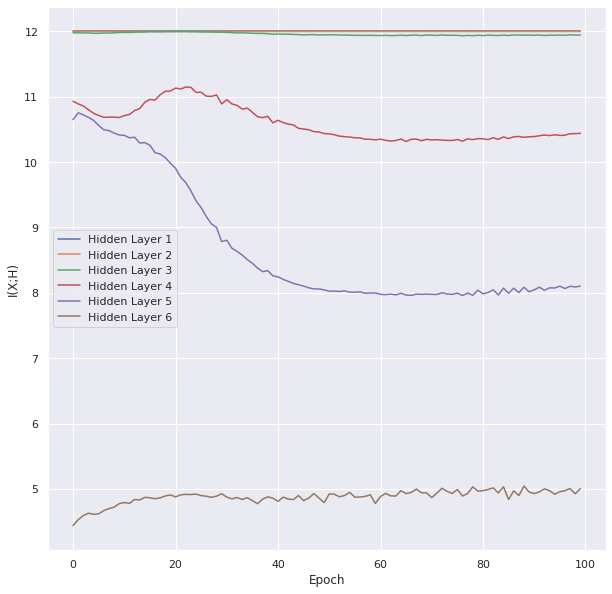

In [58]:
plot_layer_MI(np.array(MI_XH[:]), "I(X;H)")

<ipython-input-45-ff9e28970de9>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


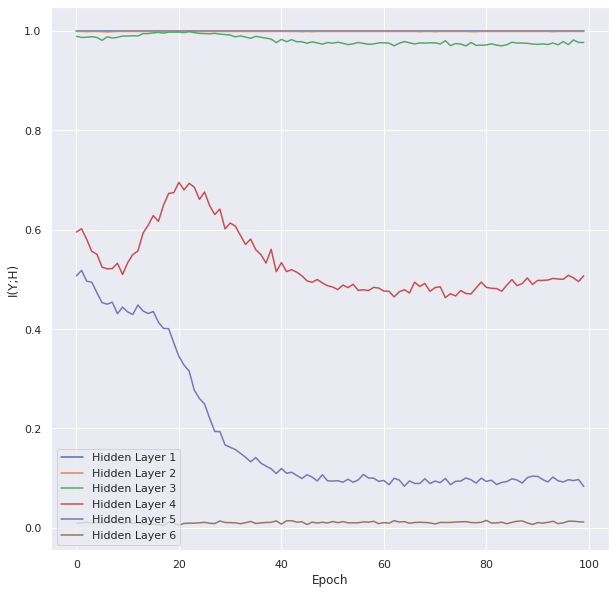

In [47]:
plot_layer_MI(np.array(MI_YH[:]), "I(Y;H)")

In [491]:
import matplotlib

100%|██████████| 100/100 [00:00<00:00, 367.48it/s]
<ipython-input-488-ff9e28970de9>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


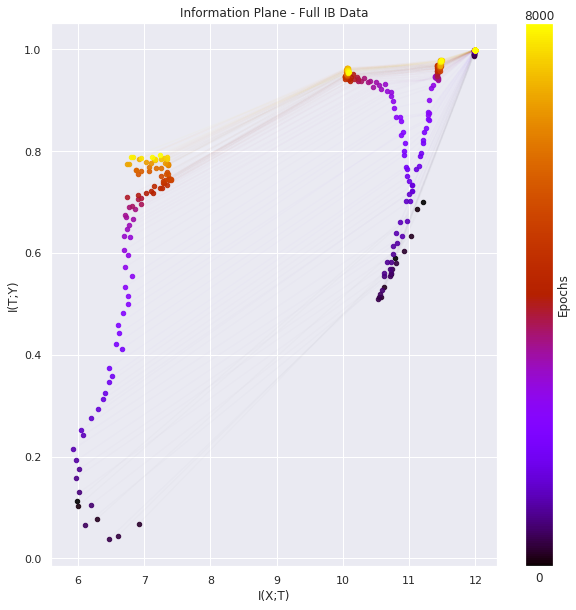

In [492]:
plot_info_plan(np.array(MI_XH[:]), np.array(MI_YH[:]))

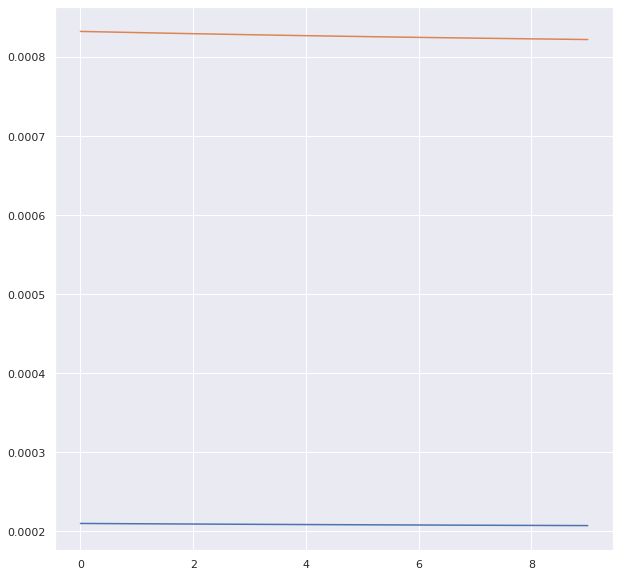

In [243]:
plt.plot(tr.train_loss)
plt.plot(tr.val_loss)

In [244]:
mutual_inf.

SyntaxError: invalid syntax (<ipython-input-244-49de674caa42>, line 1)

In [303]:
import numpy as np

def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse

def bin_calc_information(inputdata, layerdata, num_of_bins):
    p_xs, unique_inverse_x = get_unique_probs(inputdata)
    
    bins = np.linspace(-1, 1, num_of_bins, dtype='float32') 
    digitized = bins[np.digitize(np.squeeze(layerdata.reshape(1, -1)), bins) - 1].reshape(len(layerdata), -1)
    p_ts, _ = get_unique_probs( digitized )
    #print(p_ts)
    H_LAYER = -np.sum(p_ts * np.log2(p_ts))
    #print(H_LAYER)
    H_LAYER_GIVEN_INPUT = 0.
    print(unique_inverse_x)
    for xval in np.arange(len(p_xs)):
        p_t_given_x, _ = get_unique_probs(digitized[unique_inverse_x == xval, :])
        #print(p_t_given_x)
        H_LAYER_GIVEN_INPUT += - p_xs[xval] * np.sum(p_t_given_x * np.log2(p_t_given_x))
    #print(H_LAYER_GIVEN_INPUT)
    return H_LAYER - H_LAYER_GIVEN_INPUT

def bin_calc_information2(labelixs, layerdata, binsize):
    # This is even further simplified, where we use np.floor instead of digitize
    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs( digitized )
        return -np.sum(p_ts * np.log2(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        H_LAYER_GIVEN_OUTPUT += ixs.mean() * get_h(layerdata[ixs,:])
    return H_LAYER, H_LAYER - H_LAYER_GIVEN_OUTPUT

In [304]:
from __future__ import print_function
import numpy as np

# Original MI computation code from https://github.com/ravidziv/IDNNs

def extract_probs(label, x):
    """calculate the probabilities of the given data and labels p(x), p(y) and (y|x)"""
    pys = np.sum(label, axis=0) / float(label.shape[0])
    b = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    unique_array, unique_indices, unique_inverse_x, unique_counts = \
        np.unique(b, return_index=True, return_inverse=True, return_counts=True)
    unique_a = x[unique_indices]
    b1 = np.ascontiguousarray(unique_a).view(np.dtype((np.void, unique_a.dtype.itemsize * unique_a.shape[1])))
    pxs = unique_counts / float(np.sum(unique_counts))
    p_y_given_x = []
    for i in range(0, len(unique_array)):
        indexs = unique_inverse_x == i
        py_x_current = np.mean(label[indexs, :], axis=0)
        p_y_given_x.append(py_x_current)
    p_y_given_x = np.array(p_y_given_x).T
    b_y = np.ascontiguousarray(label).view(np.dtype((np.void, label.dtype.itemsize * label.shape[1])))
    unique_array_y, unique_indices_y, unique_inverse_y, unique_counts_y = \
        np.unique(b_y, return_index=True, return_inverse=True, return_counts=True)
    pys1 = unique_counts_y / float(np.sum(unique_counts_y))
    return pys, pys1, p_y_given_x, b, unique_a, unique_inverse_x, unique_inverse_y, pxs

def calc_information_sampling(data, bins, pys1, pxs, label, b, p_YgX, unique_inverse_x,  unique_inverse_y):
    bins = bins.astype(np.float32)
    num_of_bins = bins.shape[0]
    # bins = stats.mstats.mquantiles(np.squeeze(data.reshape(1, -1)), np.linspace(0,1, num=num_of_bins))
    # hist, bin_edges = np.histogram(np.squeeze(data.reshape(1, -1)), normed=True)
    digitized = bins[np.digitize(np.squeeze(data.reshape(1, -1)), bins) - 1].reshape(len(data), -1)
    b2 = np.ascontiguousarray(digitized).view(
        np.dtype((np.void, digitized.dtype.itemsize * digitized.shape[1])))
    unique_array, unique_inverse_t, unique_counts = \
        np.unique(b2, return_index=False, return_inverse=True, return_counts=True)
    p_ts = unique_counts / float(sum(unique_counts))
    PXs, PYs = np.asarray(pxs).T, np.asarray(pys1).T
    local_IXT, local_ITY = calc_information_from_mat(PXs, PYs, p_ts, digitized, unique_inverse_x, unique_inverse_y,
                                                     unique_array)
    return local_IXT, local_ITY

def calc_condtion_entropy(px, t_data, unique_inverse_x):
    # Condition entropy of t given x
    H2X_array = np.array(list(
        calc_entropy_for_specipic_t(t_data[unique_inverse_x == i, :], px[i])
                                   for i in range(px.shape[0])))
    H2X = np.sum(H2X_array)
    return H2X


def calc_information_from_mat(px, py, ps2, data, unique_inverse_x, unique_inverse_y, unique_array):
    """Calculate the MI based on binning of the data"""
    H2 = -np.sum(ps2 * np.log2(ps2))
    H2X = calc_condtion_entropy(px, data, unique_inverse_x)
    H2Y = calc_condtion_entropy(py.T, data, unique_inverse_y)
    IY = H2 - H2Y
    IX = H2 - H2X
    return IX, IY

def calc_entropy_for_specipic_t(current_ts, px_i):
    """Calc entropy for specipic t"""
    b2 = np.ascontiguousarray(current_ts).view(
        np.dtype((np.void, current_ts.dtype.itemsize * current_ts.shape[1])))
    unique_array, unique_inverse_t, unique_counts = \
        np.unique(b2, return_index=False, return_inverse=True, return_counts=True)
    p_current_ts = unique_counts / float(sum(unique_counts))
    p_current_ts = np.asarray(p_current_ts, dtype=np.float64).T
    H2X = px_i * (-np.sum(p_current_ts * np.log2(p_current_ts)))
    return H2X

In [305]:
pys, pys1, p_YgX, b, unique_a, unique_inverse_x, unique_inverse_y, pxs = extract_probs(mutual_inf.y_onehot, mutual_inf.X)

In [306]:
test_num_of_bins = 30
bins = np.linspace(-1, 1, test_num_of_bins)

In [342]:
layer_bins = [-1.0001]

In [343]:
layer = tr.hidden_activations[0][0]

In [344]:
unique = np.unique(np.squeeze(layer.reshape(1,-1)))

In [345]:
np.setdiff1d(unique,layer_bins)

array([-0.92024475, -0.91211206, -0.91137445, ...,  0.97002053,
        0.97019756,  0.97281975], dtype=float32)

In [349]:
borders=sorted(np.setdiff1d(unique,layer_bins))

In [350]:
unique

array([-0.92024475, -0.91211206, -0.91137445, ...,  0.97002053,
        0.97019756,  0.97281975], dtype=float32)

In [351]:
borders

[-0.92024475,
 -0.91211206,
 -0.91137445,
 -0.9102076,
 -0.91008365,
 -0.90944314,
 -0.90329915,
 -0.9009801,
 -0.9001421,
 -0.89992726,
 -0.8998694,
 -0.8994344,
 -0.898428,
 -0.897979,
 -0.89734244,
 -0.89658076,
 -0.8965211,
 -0.8963967,
 -0.8963369,
 -0.8962687,
 -0.89624316,
 -0.8962089,
 -0.89522964,
 -0.8938079,
 -0.8937467,
 -0.8937215,
 -0.89366025,
 -0.8929388,
 -0.8928771,
 -0.89285433,
 -0.89280677,
 -0.892745,
 -0.89264953,
 -0.89261645,
 -0.8925545,
 -0.89234936,
 -0.8911016,
 -0.8903336,
 -0.8902686,
 -0.89020544,
 -0.8901795,
 -0.89011633,
 -0.89008987,
 -0.89007396,
 -0.8900107,
 -0.88998467,
 -0.88993865,
 -0.8899214,
 -0.8898753,
 -0.88984925,
 -0.88978595,
 -0.88903975,
 -0.8889759,
 -0.8885071,
 -0.88772196,
 -0.8872452,
 -0.88718045,
 -0.88677835,
 -0.8864176,
 -0.8863524,
 -0.8863256,
 -0.8862781,
 -0.88626033,
 -0.88621277,
 -0.88618594,
 -0.8861206,
 -0.8860768,
 -0.8860114,
 -0.8859845,
 -0.88591903,
 -0.8835006,
 -0.8834338,
 -0.8832947,
 -0.88322777,
 -0.883

In [307]:
local_IXT, local_ITY = calc_information_sampling(np.array(tr.hidden_activations[9][3]), bins, pys1, pxs, mutual_inf.y_onehot, b, p_YgX, unique_inverse_x, unique_inverse_y)

In [308]:
local_IXT, local_ITY

(8.490461701710768, 0.23215448742875466)

In [309]:
bin_calc_information2(mutual_inf.y_idx_label, tr.hidden_activations[9][3], binsize=0.07)

(8.424648725228959, 0.2266224253479603)

In [311]:
bin_calc_information(mutual_inf.X, tr.hidden_activations[0][1], test_num_of_bins)

[2455 3382 2080 ... 3358 3741 1213]


12.0

In [302]:
mutual_inf.mi_binning(mutual_inf.y_idx_label, tr.hidden_activations[0][1])


[0.00024414 0.00024414 0.00024414 ... 0.00024414 0.00024414 0.00024414] None

[0.00047214 0.00047214 0.00047214 ... 0.00047214 0.00047214 0.00047214] None
11.048486873992335

[0.00050556 0.00050556 0.00050556 ... 0.00050556 0.00050556 0.00050556] None
10.949826710759112


(12.0, 0.9991571208502705)

In [285]:
a = [0.03344727, 0.00048828, 0.07592773, 0.09521484, 0.1940918,  0.21777344,
 0.00585938, 0.01611328, 0.05102539, 0.03442383, 0.15820312, 0.11743164]
[0.03344727 0.00048828 0.07592773 0.09521484 0.1940918  0.21777344
 0.00585938 0.01611328 0.05102539 0.03442383 0.15820312 0.11743164]

In [286]:
b = [0.03344727, 0.21777344, 0.1940918,  0.11743164, 0.15820312, 0.07592773,
 0.09521484, 0.03442383, 0.05102539, 0.00585938, 0.01611328, 0.00048828]

In [287]:
sorted(a)

[0.00048828,
 0.00585938,
 0.01611328,
 0.03344727,
 0.03442383,
 0.05102539,
 0.07592773,
 0.09521484,
 0.11743164,
 0.15820312,
 0.1940918,
 0.21777344]

In [288]:
sorted(b)

[0.00048828,
 0.00585938,
 0.01611328,
 0.03344727,
 0.03442383,
 0.05102539,
 0.07592773,
 0.09521484,
 0.11743164,
 0.15820312,
 0.1940918,
 0.21777344]

In [ ]:
a

In [33]:
import multiprocessing
from joblib import Parallel, delayed

NUM_CORES = multiprocessing.cpu_count()


def calc_entropy_for_specipic_t(current_ts, px_i):
    """Calc entropy for specipic t"""
    #print(current_ts.shape)
    b2 = np.ascontiguousarray(current_ts).view(
        np.dtype((np.void, current_ts.dtype.itemsize * current_ts.shape[1])))
    unique_array, _, unique_counts = \
        np.unique(b2, return_index=False, return_inverse=True, return_counts=True)
    p_current_ts = unique_counts / float(sum(unique_counts))
    p_current_ts = np.asarray(p_current_ts, dtype=np.float64).T
    H2X = px_i * (-np.sum(p_current_ts * np.log2(p_current_ts)))
    return H2X


def calc_condtion_entropy(px, t_data, unique_inverse_x):
    # Condition entropy of t given x
    H2X_array = np.array(
        Parallel(n_jobs=NUM_CORES)(delayed(calc_entropy_for_specipic_t)(t_data[unique_inverse_x == i, :], px[i])
                                   for i in range(px.shape[0])))
    H2X = np.sum(H2X_array)
    return H2X


def calc_information_from_mat(px, py, ps2, data, unique_inverse_x, unique_inverse_y, unique_array):
    """Calculate the MI based on binning of the data"""
    H2 = -np.sum(ps2 * np.log2(ps2))
    H2X = calc_condtion_entropy(px, data, unique_inverse_x)
    H2Y = calc_condtion_entropy(py.T, data, unique_inverse_y)
    IY = H2 - H2Y
    IX = H2 - H2X
    return IX, IY


def calc_probs(t_index, unique_inverse, label, b, b1, len_unique_a):
    """Calculate the p(x|T) and p(y|T)"""
    indexs = unique_inverse == t_index
    p_y_ts = np.sum(label[indexs], axis=0) / label[indexs].shape[0]
    unique_array_internal, unique_counts_internal = \
        np.unique(b[indexs], return_index=False, return_inverse=False, return_counts=True)
    indexes_x = np.where(np.in1d(b1, b[indexs]))
    p_x_ts = np.zeros(len_unique_a)
    p_x_ts[indexes_x] = unique_counts_internal / float(sum(unique_counts_internal))
    return p_x_ts, p_y_ts

In [31]:
def calc_information_sampling(data, bins, pys1, pxs, label, b, b1, len_unique_a, p_YgX, unique_inverse_x,
                              unique_inverse_y):
    bins = bins.astype(np.float32)
    #num_of_bins = bins.shape[0]
    # bins = stats.mstats.mquantiles(np.squeeze(data.reshape(1, -1)), np.linspace(0,1, num=num_of_bins))
    # hist, bin_edges = np.histogram(np.squeeze(data.reshape(1, -1)), normed=True)
    digitized = bins[np.digitize(np.squeeze(data.reshape(1, -1)), bins) - 1].reshape(len(data), -1)
    b2 = np.ascontiguousarray(digitized).view(
        np.dtype((np.void, digitized.dtype.itemsize * digitized.shape[1])))
    unique_array, unique_inverse_t, unique_counts = \
        np.unique(b2, return_index=False, return_inverse=True, return_counts=True)
    p_ts = unique_counts / float(sum(unique_counts))
    PXs, PYs = np.asarray(pxs).T, np.asarray(pys1).T
    local_IXT, local_ITY = calc_information_from_mat(PXs, PYs, p_ts, digitized, unique_inverse_x, unique_inverse_y,unique_array)
    return local_IXT, local_ITY

In [34]:
def calc_information_for_layer_with_other(data, bins, unique_inverse_x, unique_inverse_y, label,
                                          b, b1, len_unique_a, pxs, p_YgX, pys1,layer,num_of_bins):
    local_IXT, local_ITY = calc_information_sampling(data, bins, pys1, pxs, label, b, b1,
                             len_unique_a, p_YgX, unique_inverse_x,unique_inverse_y)
    params = {}
    params['local_IXT'] = local_IXT
    params['local_ITY'] = local_ITY
    return params

In [35]:
def calc_information_for_epoch(iter_index, interval_information_display,ws_iter_index, bins, unique_inverse_x,
                               unique_inverse_y, label, b, b1,
                               len_unique_a, pys, pxs, py_x, pys1, model_path,
                               input_size, layerSize, num_of_bins,per_layer_bins=False,
                               num_of_samples=100, sigma=0.5, ss=[], ks=[]):
    """Calculate the information for all the layers for specific epoch"""
    np.random.seed(None)
    if per_layer_bins:
        params = np.array(
		[calc_information_for_layer_with_other(data=ws_iter_index[i], bins=bins[i], unique_inverse_x=unique_inverse_x,
                                unique_inverse_y=unique_inverse_y, label=label,
                                 b=b, b1=b1, len_unique_a=len_unique_a, pxs=pxs,
                                 p_YgX=py_x, pys1=pys1,layer=i,num_of_bins=num_of_bins)
            for i in range(len(ws_iter_index))])
    else:
        params = np.array(
		[calc_information_for_layer_with_other(data=ws_iter_index[i], bins=bins, unique_inverse_x=unique_inverse_x,
			                    unique_inverse_y=unique_inverse_y, label=label,
	                             b=b, b1=b1, len_unique_a=len_unique_a, pxs=pxs,
                                 p_YgX=py_x, pys1=pys1,layer=i,num_of_bins=num_of_bins)
			 for i in range(len(ws_iter_index))])
    if np.mod(iter_index, interval_information_display) == 0:
        print('Calculated The information of epoch number - {0}'.format(iter_index))
    return params


def extract_probs(label, x):
    """calculate the probabilities of the given data and labels p(x), p(y) and (y|x) """
    pys = np.sum(label, axis=0) / float(label.shape[0])
    b = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    unique_array, unique_indices, unique_inverse_x, unique_counts = \
    np.unique(b, return_index=True, return_inverse=True, return_counts=True)
    unique_a = x[unique_indices]
    b1 = np.ascontiguousarray(unique_a).view(np.dtype((np.void, unique_a.dtype.itemsize * unique_a.shape[1])))
    pxs = unique_counts / float(np.sum(unique_counts))
    p_y_given_x = []
    for i in range(0, len(unique_array)):
        indexs = unique_inverse_x == i
        py_x_current = np.mean(label[indexs, :], axis=0)
        p_y_given_x.append(py_x_current)
    p_y_given_x = np.array(p_y_given_x).T
    b_y = np.ascontiguousarray(label).view(np.dtype((np.void, label.dtype.itemsize * label.shape[1])))
    unique_array_y, unique_indices_y, unique_inverse_y, unique_counts_y = \
    np.unique(b_y, return_index=True, return_inverse=True, return_counts=True)
    pys1 = unique_counts_y / float(np.sum(unique_counts_y))
    return pys, pys1, p_y_given_x, b1, b, unique_a, unique_inverse_x, unique_inverse_y, pxs

def get_information(ws, x, label, num_of_bins, interval_information_display, \
                    model, layerSize, py_hats=0,multiple_bins=True,kde=False,
                    per_layer_bins=False, lower=False, maxentropy=True):
    """Calculate the information for the network for all the epochs and all the layers"""
    pys, pys1, p_y_given_x, b1, b, unique_a, unique_inverse_x, unique_inverse_y, pxs = extract_probs(label, x)
    np.set_printoptions(edgeitems=30)
    if per_layer_bins:
        multiple_bins=per_layer_bins
    print('Start calculating the information...')

    multiple_bins=False
    bins = np.linspace(-1, 1, num_of_bins)
    label = np.array(label).astype(np.float)
    params = np.array(Parallel(n_jobs=NUM_CORES
        )(delayed(calc_information_for_epoch)
        (i, interval_information_display, multiple_bins, ws[i], bins, unique_inverse_x, unique_inverse_y,
         label,
         b, b1, len(unique_a), pys,
         pxs, p_y_given_x, pys1, None, x.shape[1], layerSize,num_of_bins=num_of_bins)
        for i in range(len(ws))))
    return params

In [ ]:
get_information(np.array(tr.hidden_activations), mutual_inf.X, mutual_inf.y_flat, 30, 1000, None, )